<a href="https://colab.research.google.com/github/mrsalty/unibo-ai/blob/main/EmotionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Detection 

## Task 

The task consists in creating a Emotion Detection model, able to recognise the emotion expressed in a given text/sentence. 

We are expected to use `f1-macro average` metric to avaluate our models.

# Analysis

To approach this task several architectures have been considered. 

The ideal and natural approach would be to use a **Transformer** architecture, which is kind of the state of the art in the NLP field. 

After a bit of experiments though this approach revealed to require big pre-trained models (such as BERT-like architectures) with hundred(s) of million parameters for training.


Alternative architectures have been therefore considered which don't require such massive models and resources.


**LSTM** and **GRU** are similar architectures, both very performing in NLP field, and they don't require such massive resources.


This notebook is an approach the the problem using these architectures with an analysis of the performance obtained.



In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
import seaborn as sns
import tensorflow as tf
import collections
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM, Bidirectional, Input, GRU
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras import models, layers, backend as K
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from numpy import array, asarray, zeros
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight 

# download nltk resources
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# global params
VOCAB_SIZE = 5000
NUM_EPOCHS = 20
BATCH_SIZE = 64

# Load the data

In [ ]:
# load data from files
train_ds = pd.read_csv("train_ekmann.csv")
test_ds = pd.read_csv("test_ekmann.csv")
val_ds = pd.read_csv("val_ekmann.csv")

# remove Id column
train_ds = train_ds.drop('Id', 1)
test_ds = test_ds.drop('Id', 1)
val_ds = val_ds.drop('Id', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if __name__ == '__main__':


# Data visualization

In [ ]:
train_ds.shape

(43410, 2)

In [ ]:
train_ds.head

<bound method NDFrame.head of                                                     Text   Emotion
0      My favourite food is anything I didn't have to...   neutral
1      Now if he does off himself, everyone will thin...   neutral
2                         WHY THE FUCK IS BAYLESS ISOING     anger
3                            To make her feel threatened      fear
4                                 Dirty Southern Wankers     anger
...                                                  ...       ...
43405  Added you mate well I’ve just got the bow and ...       joy
43406  Always thought that was funny but is it a refe...  surprise
43407  What are you talking about? Anything bad that ...     anger
43408            More like a baptism, with sexy results!       joy
43409                                    Enjoy the ride!       joy

[43410 rows x 2 columns]>

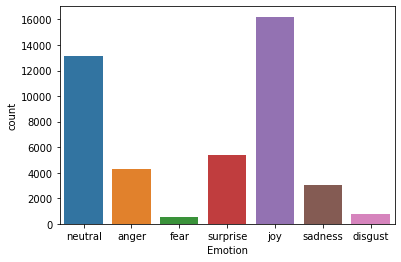

In [ ]:
# emotion distribution
sns.countplot(x='Emotion', data=train_ds)

# Preprocessing

Visually analysing the data shows the need for some preprocessing. 

We proceed first removing punctuation and numbers, multiple spaces and converting to lower case.

We then apply `lemmatization` which considers a language’s full vocabulary to apply a morphological analysis to words. The lemma is then a common way to represent morphological similar words (eg: 'studies' and 'studying' will be lemmatized to 'study').

The text is now ready to be `tokenized`, so an index is assigned to each word and then the text is translated into an array of indexes. We then pad all datasets to the maximum length found so they all have the same number of columns.

As last step we then, after having mapped each class into an integer, `hot encode` all three prediction datasets, so to model our output layers with dimension 7.

It's worth observing that because we are provided of the three datasets for training, validation and test we will apply the same preprocessing to all of them, as much as we would apply preprocessing to the entire dataset before doing the `train_test_split`.

In [ ]:
def preprocess_text(sentence):
    # to lower case
    sentence = sentence.lower()
    # remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [ ]:
# lemmatize
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [ ]:
def map_emotion(emotion):
    if emotion == "neutral":
        return 0
    elif emotion == "anger":
        return 1
    elif emotion == "sadness":
        return 2
    elif emotion == "fear":
        return 3
    elif emotion == "disgust":
        return 4
    elif emotion == "surprise":
        return 5
    elif emotion == "joy":
        return 6
    else:
      return -1

In [ ]:
# preprocess all dataframes
train_ds['Text'] = train_ds['Text'].apply(lambda x: preprocess_text(x))
train_ds['Text'] = train_ds['Text'].apply(lambda x: lemmatize(x))
print(train_ds['Text'][0])

test_ds['Text'] = test_ds['Text'].apply(lambda x: preprocess_text(x))
test_ds['Text'] = test_ds['Text'].apply(lambda x: lemmatize(x))
print(test_ds['Text'][0])

val_ds['Text'] = val_ds['Text'].apply(lambda x: preprocess_text(x))
val_ds['Text'] = val_ds['Text'].apply(lambda x: lemmatize(x))
print(val_ds['Text'][0])

['my', 'favourite', 'food', 'is', 'anything', 'i', 'didn', 't', 'have', 'to', 'cook', 'myself']
['i', 'm', 'really', 'sorry', 'about', 'your', 'situation', 'although', 'i', 'love', 'the', 'name', 'sapphira', 'cirilla', 'and', 'scarlett']
['is', 'this', 'in', 'new', 'orleans', 'i', 'really', 'feel', 'like', 'this', 'is', 'new', 'orleans']


In [ ]:
# prepare arrays for model
y_train = train_ds['Emotion'].values.tolist()
y_train = np.array(list(map(lambda x: map_emotion(x), y_train)))
X_train = train_ds["Text"].values.tolist()

y_test = test_ds['Emotion'].values.tolist()
y_test = np.array(list(map(lambda x: map_emotion(x), y_test)))
X_test = test_ds["Text"].values.tolist()

y_val = val_ds['Emotion'].values.tolist()
y_val = np.array(list(map(lambda x: map_emotion(x), y_val)))
X_val = val_ds["Text"].values.tolist()

In [ ]:
# initialize tokenizer on train set 
tk = Tokenizer(num_words=VOCAB_SIZE,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)
print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

# transform words in sequences of int
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)
X_val_seq = tk.texts_to_sequences(X_val)

print('"{}" is converted into {}'.format(X_train[0], X_train_seq[0]))

Fitted tokenizer on 43410 documents
Top 5 most common words are: [('i', 20778), ('the', 18003), ('a', 14536), ('to', 12600), ('you', 11459)]
"['my', 'favourite', 'food', 'is', 'anything', 'i', 'didn', 't', 'have', 'to', 'cook', 'myself']" is converted into [18, 1061, 471, 9, 202, 1, 112, 14, 26, 4, 2784, 350]


In [ ]:
# padding each array to max lenght of sequences within the array
X_train_seq = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, padding="post")
X_test_seq = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, padding="post")
X_val_seq = tf.keras.preprocessing.sequence.pad_sequences(X_val_seq, padding="post")

print("Shapes before padding:")
print(X_train_seq.shape)
print(X_test_seq.shape)
print(X_val_seq.shape)

# pad each array to the longest of the three arrays so they are all same length
max_padding = max(max(X_train_seq.shape[1], X_test_seq.shape[1]), X_val_seq.shape[1])
print(max_padding)

if (X_train_seq.shape[1] < max_padding):
    padding_val_train = max_padding - X_train_seq.shape[1] 
    X_train_seq = np.pad(X_train_seq, [(0, 0), (0, padding_val_train)], mode='constant', constant_values=0)

if (X_test_seq.shape[1] < max_padding):
    padding_val_test = max_padding - X_test_seq.shape[1]
    X_test_seq = np.pad(X_test_seq, [(0, 0), (0, padding_val_test)], mode='constant', constant_values=0)

if (X_val_seq.shape[1] < max_padding):
    padding_val_val = max_padding - X_val_seq.shape[1] 
    X_val_seq = np.pad(X_val_seq, [(0, 0), (0, padding_val_val)], mode='constant', constant_values=0)

print("Shapes after padding:")
print(X_train_seq.shape)
print(X_test_seq.shape)
print(X_val_seq.shape)

Shapes before padding:
(43410, 32)
(5427, 30)
(5426, 30)
32
Shapes after padding:
(43410, 32)
(5427, 32)
(5426, 32)


In [ ]:
# one hot encoding
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)
y_val_oh = to_categorical(y_val)

print('eg: {} -> {}'.format(y_train[10], y_train_oh[10]))

eg: 5 -> [0. 0. 0. 0. 0. 1. 0.]


# Bidirectional LSTM

A Bidirectional LSTM (Long Short Term Memory) is a RNN used primarily on NLP. Unlike standard LSTM, the input flows in both directions. It’s a powerful tool for modelling the sequential dependencies between words and phrases in both directions of the sequence. For these reasons this model was chosen as appropriate for this task.




## Build model

The architecture is composed of an `Embedding` layer: this layer enables us to convert each word into a fixed length vector of defined size. The resultant vector is a `Dense` layer which has real values. The fixed length of word vectors helps to represent words in a better way along with reduced dimensions.

We then apply a strong (0.8) `Dropout` layer which helps avoiding a fast overfitting of the model. 

Two `bidirectional LSTM` layers of same size are then applied to then feed the output layer, a `Dense` layer with activation `softmax` which normalizes the output of our distribution to each class.

We use an `EarlyStopping` callback with pretty low patience, as the model with the training dataset (pretty small in size) tends to overfit very quickly, so we expect this to run in quite few epochs.

In [ ]:
input = Input(shape=(max_padding,))
x = Embedding(input_dim=VOCAB_SIZE,output_dim=256, input_length=max_padding)(input)
x = Dropout(0.8)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(128))(x)
x = Dense(7, activation='softmax')(x)
model_lstm = Model(inputs=input, outputs=x)
model_lstm.summary()

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 32)]              0         
                                                                 
 embedding_32 (Embedding)    (None, 32, 256)           1280000   
                                                                 
 dropout_32 (Dropout)        (None, 32, 256)           0         
                                                                 
 bidirectional_32 (Bidirecti  (None, 32, 256)          394240    
 onal)                                                           
                                                                 
 bidirectional_33 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dense_48 (Dense)            (None, 7)                 179

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience = 2, verbose=1)

model_lstm.compile(optimizer='adam'
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

history_lstm = model_lstm.fit(X_train_seq
                    , y_train_oh
                    , epochs=NUM_EPOCHS
                    , batch_size=BATCH_SIZE
                    , validation_data=(X_val_seq, y_val_oh)
                    , verbose=1
                    , callbacks=[early_stopping_callback])

Epoch 1/20
679/679 [==============================] - 16s 15ms/step - loss: 1.2777 - accuracy: 0.5270 - val_loss: 1.0785 - val_accuracy: 0.6119
Epoch 2/20
679/679 [==============================] - 9s 13ms/step - loss: 1.0638 - accuracy: 0.6114 - val_loss: 1.0004 - val_accuracy: 0.6369
Epoch 3/20
679/679 [==============================] - 9s 13ms/step - loss: 0.9892 - accuracy: 0.6396 - val_loss: 0.9812 - val_accuracy: 0.6373
Epoch 4/20
679/679 [==============================] - 9s 13ms/step - loss: 0.9473 - accuracy: 0.6531 - val_loss: 0.9743 - val_accuracy: 0.6358
Epoch 5/20
679/679 [==============================] - 9s 13ms/step - loss: 0.9149 - accuracy: 0.6660 - val_loss: 0.9717 - val_accuracy: 0.6441
Epoch 6/20
679/679 [==============================] - 9s 13ms/step - loss: 0.8896 - accuracy: 0.6711 - val_loss: 0.9716 - val_accuracy: 0.6380
Epoch 7/20
679/679 [==============================] - 9s 13ms/step - loss: 0.8633 - accuracy: 0.6818 - val_loss: 0.9750 - val_accuracy: 0.639

## Prediction and scores

In [ ]:
y_true, y_pred = y_test_oh, model_lstm.predict(X_test_seq)

In [ ]:
class_names = np.unique(train_ds["Emotion"])

# hot encode y_pred
y_pred_cat = to_categorical(np.argmax(y_pred, axis=1), 7)

# classification report
print("Classification report (LSTM):")
print()
print(classification_report(y_true, y_pred_cat, target_names=class_names))

# f1 macro score
print("Macro avg f1 score:", f1_score(y_true, y_pred_cat, average='macro'))

Classification report (LSTM):

              precision    recall  f1-score   support

       anger       0.59      0.68      0.63      1648
     disgust       0.49      0.45      0.47       572
        fear       0.59      0.53      0.56       355
         joy       0.66      0.68      0.67        81
     neutral       0.67      0.39      0.49       116
     sadness       0.56      0.45      0.50       677
    surprise       0.77      0.77      0.77      1978

   micro avg       0.64      0.64      0.64      5427
   macro avg       0.62      0.56      0.58      5427
weighted avg       0.64      0.64      0.64      5427
 samples avg       0.64      0.64      0.64      5427

Macro avg f1 score: 0.5840724056046386


# GRU

GRU (Gated Recurrent Unit) are very similar to LSTM with a forget gate, but they have fewer parameters, as they don't implement an output gate.

## Build the model

The architecture is composed of a first `Embedding` layer.

We then apply a strong `Dropout` (0.8) which helps avoiding fast overfitting of the model. 

A `GRU` layer is then applied followed by two `Dense` layers of same size, the last with `Relu` activation function before feeding the output layer.

In [ ]:
input = Input(shape=(max_padding,))
x = Embedding(input_dim=VOCAB_SIZE,output_dim=256, input_length=max_padding)(input)
x = Dropout(0.8)(x)
x = GRU(256)(x)
x = Dense(256, activation='relu')(x)
x = Dense(7, activation='softmax')(x)
model_gru = Model(inputs=input, outputs=x)
model_gru.summary()

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 32)]              0         
                                                                 
 embedding_33 (Embedding)    (None, 32, 256)           1280000   
                                                                 
 dropout_33 (Dropout)        (None, 32, 256)           0         
                                                                 
 gru_16 (GRU)                (None, 256)               394752    
                                                                 
 dense_49 (Dense)            (None, 256)               65792     
                                                                 
 dense_50 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 1,742,343
Trainable params: 1,742,343
Non-tr

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience = 2, verbose=1)

model_gru.compile(optimizer='adam'
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

history_gru = model_gru.fit(X_train_seq
                    , y_train_oh
                    , epochs=NUM_EPOCHS
                    , batch_size=BATCH_SIZE
                    , validation_data=(X_val_seq, y_val_oh)
                    , verbose=1
                    , callbacks=[early_stopping_callback])

Epoch 1/20
679/679 [==============================] - 6s 7ms/step - loss: 1.4632 - accuracy: 0.4185 - val_loss: 1.2090 - val_accuracy: 0.5628
Epoch 2/20
679/679 [==============================] - 4s 6ms/step - loss: 1.1789 - accuracy: 0.5703 - val_loss: 1.1029 - val_accuracy: 0.6025
Epoch 3/20
679/679 [==============================] - 4s 6ms/step - loss: 1.0705 - accuracy: 0.6113 - val_loss: 1.0277 - val_accuracy: 0.6264
Epoch 4/20
679/679 [==============================] - 4s 6ms/step - loss: 1.0001 - accuracy: 0.6363 - val_loss: 1.0055 - val_accuracy: 0.6351
Epoch 5/20
679/679 [==============================] - 4s 6ms/step - loss: 0.9553 - accuracy: 0.6531 - val_loss: 0.9803 - val_accuracy: 0.6406
Epoch 6/20
679/679 [==============================] - 4s 6ms/step - loss: 0.9173 - accuracy: 0.6642 - val_loss: 0.9751 - val_accuracy: 0.6390
Epoch 7/20
679/679 [==============================] - 4s 6ms/step - loss: 0.8876 - accuracy: 0.6743 - val_loss: 0.9797 - val_accuracy: 0.6382
Epoch 

## Prediction and scores

In [ ]:
y_true, y_pred = y_test_oh, model_gru.predict(X_test_seq)

In [ ]:
class_names = np.unique(train_ds["Emotion"])

# hot encode y_pred
y_pred_cat = to_categorical(np.argmax(y_pred, axis=1), 7)

# classification report\
print("Classification report (GRU):")
print()
print(classification_report(y_true, y_pred_cat, target_names=class_names))

# f1 macro score
print("Macro avg f1 score:", f1_score(y_true, y_pred_cat, average='macro'))

Classification report (GRU):

              precision    recall  f1-score   support

       anger       0.57      0.73      0.64      1648
     disgust       0.53      0.42      0.47       572
        fear       0.66      0.51      0.58       355
         joy       0.74      0.59      0.66        81
     neutral       0.61      0.46      0.52       116
     sadness       0.56      0.45      0.50       677
    surprise       0.80      0.76      0.78      1978

   micro avg       0.65      0.65      0.65      5427
   macro avg       0.64      0.56      0.59      5427
weighted avg       0.66      0.65      0.65      5427
 samples avg       0.65      0.65      0.65      5427

Macro avg f1 score: 0.5917907309276702


# Conclusions

The two models perform very similarly (as expected since their internal architecture is also alike) but after few runs we can observe slight better results obtained with the `GRU` model which as a plus also requires less parameters. 